In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

from superfv import EulerSolver, plot_1d_slice, plot_2d_slice
from superfv.initial_conditions import gresho_vortex

In [2]:
N = 96
T = 1
gamma = 5 / 3
M_max = 1e-1
v0 = 5.0

configs = {
    # "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        p=1,
        MUSCL=True,
        MUSCL_limiter="PP2D",
        flux_recipe=2,
    ),
    # "ZS3": dict(
    #     riemann_solver="hllc",
    #     p=3,
    #     flux_recipe=2,
    #     lazy_primitives=True,
    #     ZS=True,
    #     GL=True,
    #     include_corners=True,
    #     PAD={"rho": (0, None), "P": (0, None)},
    # ),
    # "MM3": dict(
    #     riemann_solver="hllc",
    #     p=3,
    #     flux_recipe=2,
    #     lazy_primitives=True,
    #     MOOD=True,
    #     limiting_vars="actives",
    #     cascade="muscl",
    #     MUSCL_limiter="PP2D",
    #     max_MOOD_iters=1,
    #     NAD=True,
    #     NAD_rtol=1e-2,
    #     NAD_atol=1e-8,
    #     include_corners=True,
    #     PAD={"rho": (0, None), "P": (0, None)},
    # ),
}

In [3]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(gresho_vortex, gamma=gamma, M_max=M_max, v0=v0),
        gamma=gamma,
        nx=N,
        ny=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            muscl_hancock=config.get("MUSCL", False),
            allow_overshoot=True,
            log_freq=20,
        )
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: MUSCL-Hancock
Step #3157 @ t=1.00e+00 | dt=3.17e-04 | min(rho)=1.00e+00, min(P)=5.95e+01 | (done)                 


In [4]:
def M_over_Mmax(idx, mesh, w):
    x, y, _ = mesh.get_cell_centers()
    rho = w[idx("rho")]
    vx = w[idx("vx")] - v0
    vy = w[idx("vy")]
    P = w[idx("P")]

    xc = x - 0.5
    yc = y - 0.5
    r = np.sqrt(xc**2 + yc**2)

    v_phi = vx * (-yc / r) + vy * (xc / r)

    cs2 = gamma * P / rho
    cs = np.sqrt(np.maximum(cs2, 0.0))

    M = np.abs(v_phi) / cs

    return M / M_max

/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 1 not exactly matched in mesh; using nearest: 1.00009
  warnings.warn(


(<matplotlib.image.AxesImage at 0x113f29b80>,
 <matplotlib.colorbar.Colorbar at 0x11655c260>)

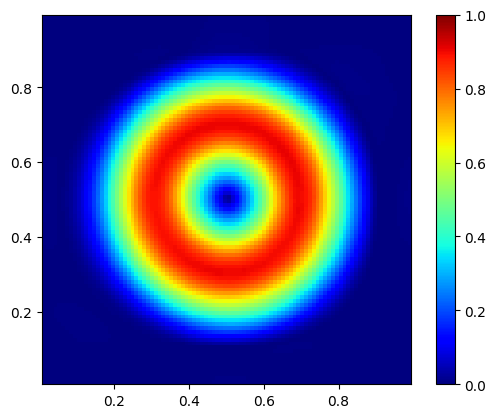

In [5]:
fig, ax = plt.subplots()

sim = sims["MUSCL-Hancock"]

plot_2d_slice(
    sim,
    ax,
    "w",
    t=1,
    colorbar=True,
    cmap="jet",
    multivar_func=M_over_Mmax,
    vmin=0,
    vmax=1,
)

/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 1 not exactly matched in mesh; using nearest: 1.00009
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0 not exactly matched in mesh; using nearest: 0.00520833
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(
/Users/jonathan/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(


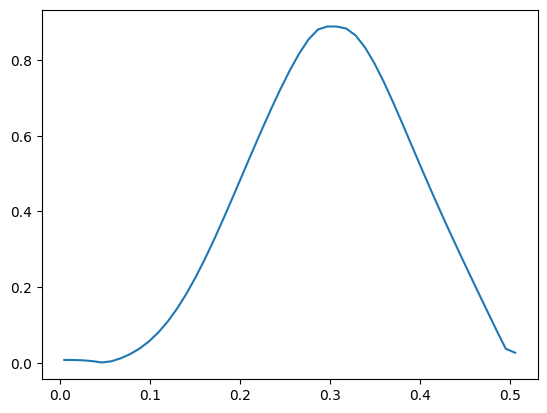

In [7]:
fig, ax = plt.subplots()

sim = sims["MUSCL-Hancock"]

plot_1d_slice(sim, ax, "w", t=1, x=(0, 0.5), y=0.5, multivar_func=M_over_Mmax)